In [10]:
# Data Processing
import pandas as pd
import numpy as np

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

from pathlib import Path
import joblib


In [11]:
gamesDF = pd.read_csv('./datasets/training_dataset.csv')
gamesDF = gamesDF.drop(columns=['HOME_L10_LOSSES', 'AWAY_L10_LOSSES', 'PERIOD', 'POINT_DIFF'])
X = gamesDF[['SECONDS_REMAINING','HOME_SCORE','AWAY_SCORE','HOME_WINS', 'HOME_LOSSES', 'AWAY_WINS', 'AWAY_LOSSES', 'HOME_L10_WINS', 'AWAY_L10_WINS']] 
y = gamesDF['HOME_WIN']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# randomized search
n_estimators = [10, 50, 100, 200]
max_depth = [2, 3, 4]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

param_dist = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}

rf_random = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=50,
    cv=3,
    random_state=42,
    n_jobs=-1,
    scoring="neg_log_loss"
)

rf_random.fit(X_train, y_train)
rf = rf_random.best_estimator_
print("Best params:", rf_random.best_params_)
print("Best CV score (accuracy):", rf_random.best_score_.round(4))
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))


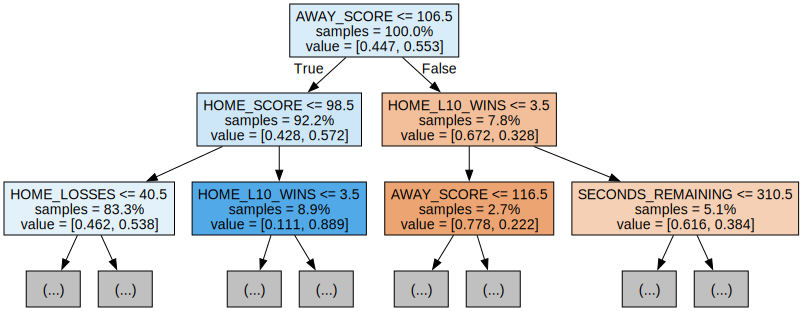

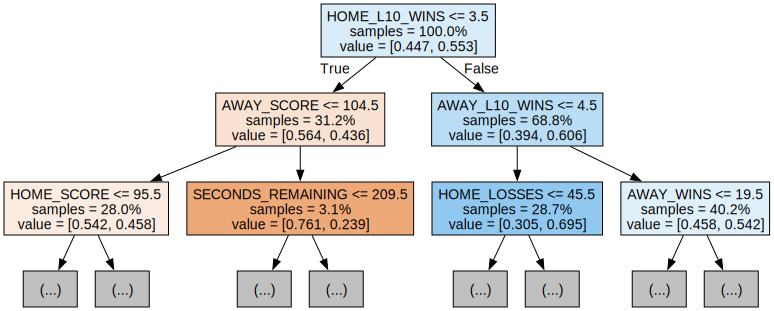

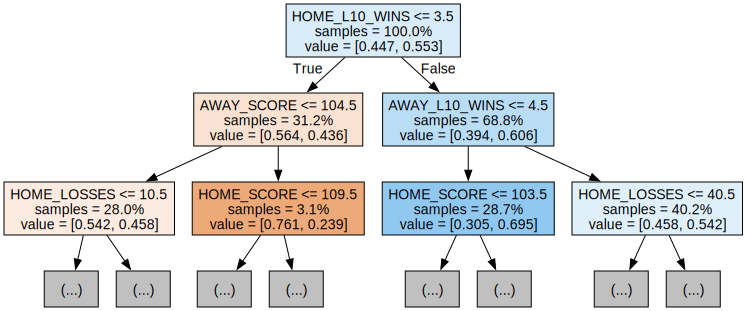

In [ ]:
for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

In [ ]:
# Custom test: win probability for a single scenario using RF
# Example: 5 min left in game, home 98 - away 92, home 40-20, away 35-25, home L10 7-3, away L10 5-5
seconds_remaining = 18  # 300
home_score, away_score = 92, 200
home_wins, home_losses = 39, 21
away_wins, away_losses = 39, 21
home_l10_wins, away_l10_wins = 0, 10

custom_df = pd.DataFrame([[
    seconds_remaining, home_score, away_score,
    home_wins, home_losses, away_wins, away_losses,
    home_l10_wins, away_l10_wins,
]], columns=X_train.columns)
proba = rf.predict_proba(custom_df)[0]
home_win_prob = proba[1]
away_win_prob = proba[0]
print(f"Scenario: {seconds_remaining}s left, Home {home_score}-{away_score} Away")
print(f"Home record: {home_wins}-{home_losses}, Away record: {away_wins}-{away_losses}")
print(f"Home L10 wins: {home_l10_wins}, Away L10 wins: {away_l10_wins}")
print(f"Home win probability: {home_win_prob:.1%}")
print(f"Away win probability: {away_win_prob:.1%}")

Scenario: 18s left, Home 92-200 Away
Home record: 39-21, Away record: 39-21
Home L10 wins: 0, Away L10 wins: 10
Home win probability: 28.3%
Away win probability: 71.7%


In [ ]:
def save_model(model, model_path_name):
    model_path = Path(model_path_name)
    joblib.dump(model, model_path)
    print(f"Model saved to {model_path.absolute()}")

save_model(rf, "random_forest_v2.joblib")

Model saved to /Users/lemons/Documents/universidad/cs/pj09-sports-betting/ml/random_forest.joblib
